In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import json
import os
import sys

sys.path.append("..")

import seaborn as sns

sns.set()
from settings import (
    random_state,
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET,
)
from sklearn.ensemble import RandomForestClassifier

In [2]:
transactions = pl.read_parquet(
    os.path.join(PROJECT_PATH, "transactions_post_feature_engineering.parquet")
)

X = transactions.drop([REGRESSION_TARGET, CLASSIFICATION_TARGET])
y_regression = transactions[REGRESSION_TARGET]
y_classification = transactions[CLASSIFICATION_TARGET]


with open("../features_used.json", "r") as f:
    feature_names = json.load(f)

with open("../categorical_features_used.json", "r") as f:
    categorical_features = json.load(f)


numerical_features = [col for col in feature_names if col not in categorical_features]

In [3]:
classifier = RandomForestClassifier(random_state=random_state, verbose=False)

X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y_classification.to_pandas(), random_state=random_state
)

classifier.fit(X_train[feature_names], y_train)


RandomForestClassifier(random_state=42, verbose=False)

In [4]:
y_train_pred = classifier.predict(X_train[feature_names])
y_test_pred = classifier.predict(X_test[feature_names])
X_train["prediction"] = y_train_pred
X_test["prediction"] = y_test_pred



In [5]:
def get_prediction_type(prediction, target):
    if prediction == 1 and target == 1:
        return "true_positive"
    elif prediction == 0 and target == 0:
        return "true_negative"
    elif prediction == 1 and target == 0:
        return "false_positive"
    elif prediction == 0 and target == 1:
        return "false_negative"
    else:
        return "unknown"

In [6]:
X_train[CLASSIFICATION_TARGET] = y_train
X_train["prediction_type"] = X_train.apply(
    lambda row: get_prediction_type(row["prediction"], row[CLASSIFICATION_TARGET]),
    axis=1,
)

X_test[CLASSIFICATION_TARGET] = y_test
X_test["prediction_type"] = X_test.apply(
    lambda row: get_prediction_type(row["prediction"], row[CLASSIFICATION_TARGET]),
    axis=1,
)

Une piste intéressante pour établir le lien entre les erreurs du modèle et les features quantitatives consiste à comparer : 
* La distribution d'une feature au sein du jeu d'apprentissage ou de test 
* La distribution d'un feature parmi les observations catégorisées à tort par le modèle (par exemple, faux positif ou faux négatif)
* Répéter le processus pour les autres features

Ceci permettrait de détécter s'il y a des valeurs "types" chez certaines features où le modèle à particulièrement du mal dans sa classification !  

In [7]:
# Cette fonction nous donne les observations des groupes qu'on souhaite étudier
def get_data_group(X, group_label):
    if group_label == "all":
        X_group = X.copy()
    if group_label == "false_positive":
        X_group = X[X["prediction_type"] == "false_positive"]
    if group_label == "false_negative":
        X_group = X[X["prediction_type"] == "false_negative"]
    if group_label == "true_positive":
        X_group = X[X["prediction_type"] == "true_positive"]
    if group_label == "true_negative":
        X_group = X[X["prediction_type"] == "true_negative"]
    return X_group

In [8]:
# On compare deux groupes de notre choix
def compare_all_features_distribution_groups(X, group_1, group_2, numerical_features):

    """
    Les 5 lignes de codes qui suivent sont une préparation pour capitaliser 
    sur la fonction displot et son argument "hue" qui gère autant de distributions que de groupes à comparer.
    Il faut alors que chaque groupe à comparer fasse partie de la même colonne qu'on donne au "hue"
    """
    X_group_1 = get_data_group(X, group_1)
    X_group_1["group"] = group_1
    X_group_2 = get_data_group(X, group_2)
    X_group_2["group"] = group_2
    X_plot = pd.concat([X_group_1, X_group_2], axis = 0)

    # Comme nous traçons des distributions, cela n'a pas de sens d'inclure des features catégorielles
    for feature in numerical_features:
        sns.displot(data = X_plot, x=feature, hue="group")
        plt.xlabel("Feature Distribution")
        plt.title("Comparing feature distribution for {} and {}".format(group_1, group_2))

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_21692\3076143496.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_group_1["group"] = group_1


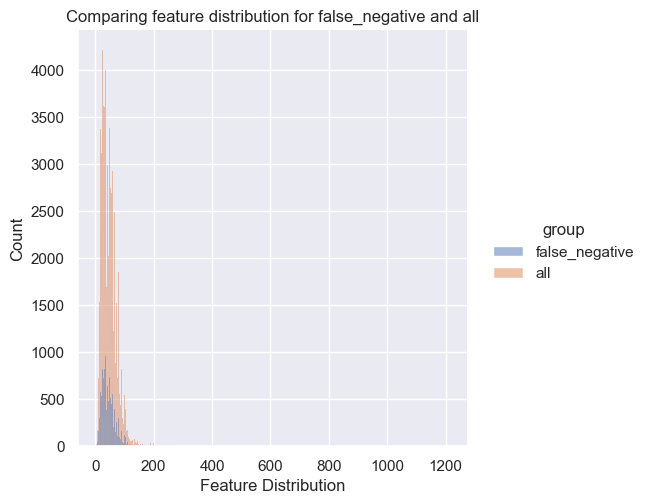

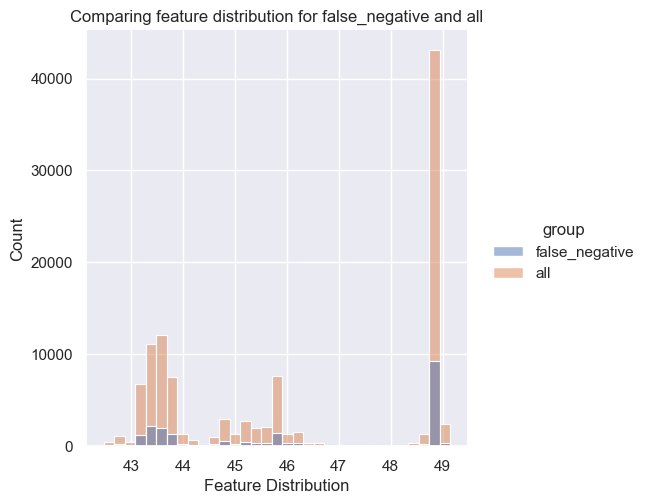

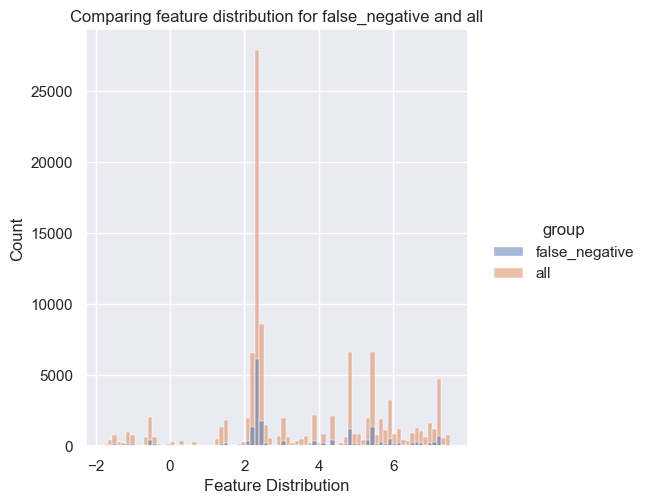

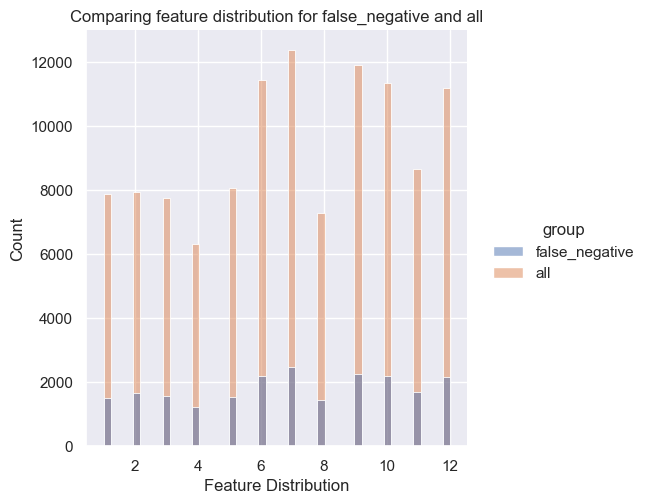

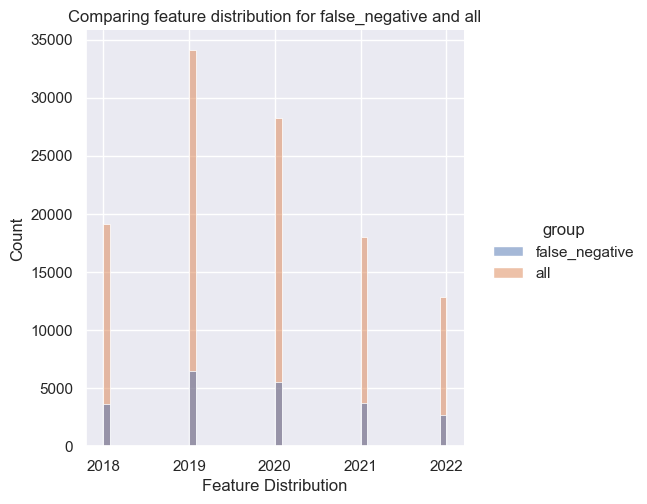

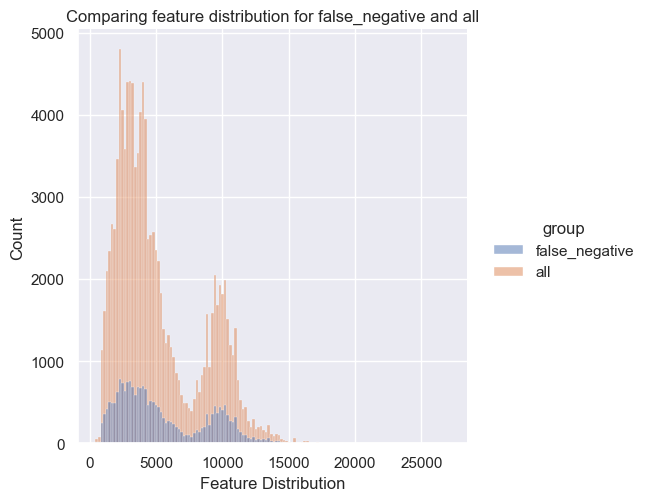

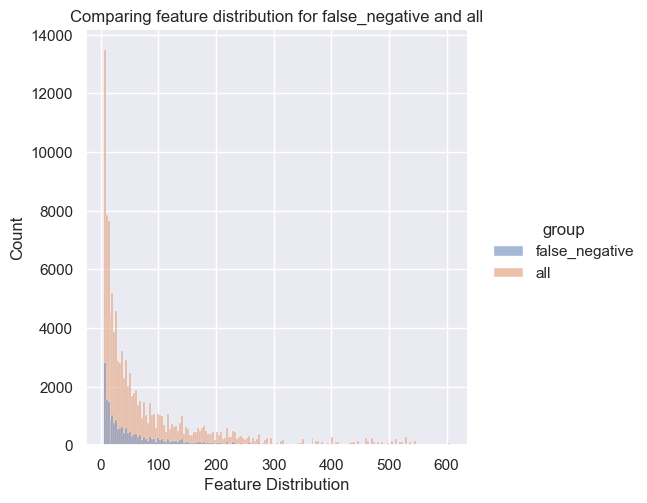

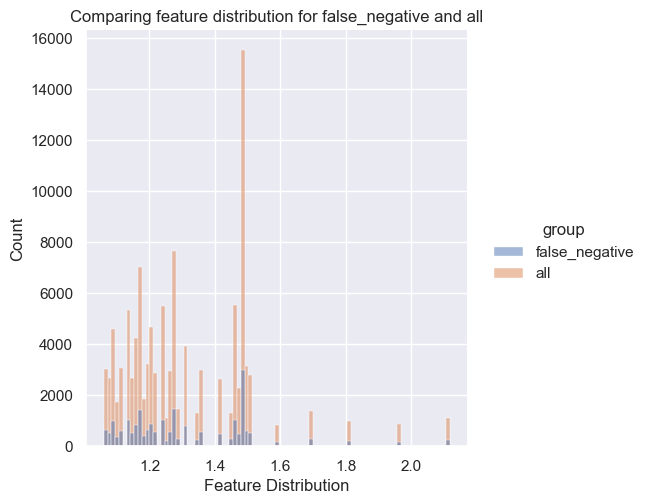

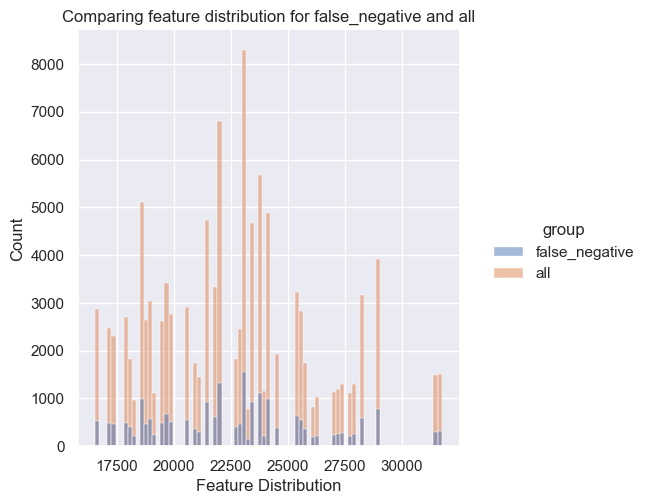

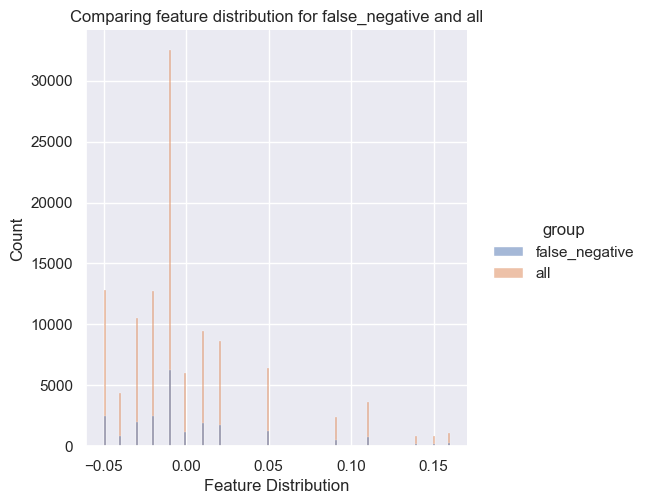

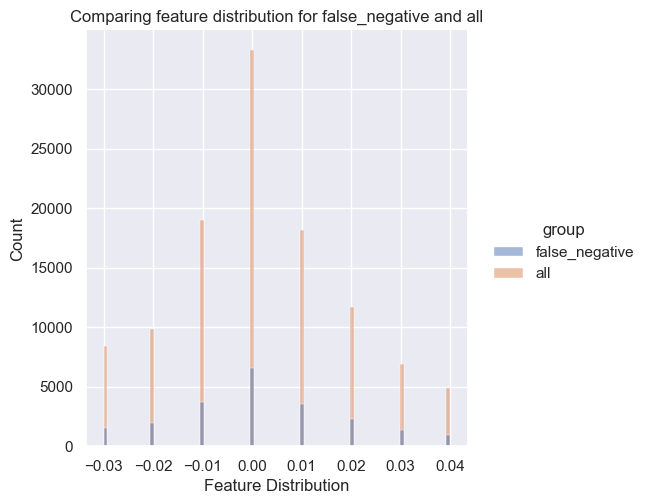

In [10]:
compare_all_features_distribution_groups(X_test, "false_negative", "all", numerical_features)

In [ ]:
compare_all_features_distribution_groups(X_test, "false_positive", "all", numerical_features)

Concernant les faux positifs et les faux négatifs, il est difficile de conclure quoi que ce soit ! En effet, les distributions des faux positifs et des faux négatifs épousent parfaitement les distributions du jeu de test.

On pourrait pousser l'analyse plus loin et se concentrer sur d'autres groupes : 
* L'ensemble des faux négatifs avec une probabilité prédite inférieure à 10% : Ce sont les observations avec lesquelles le modèle est particulièrement dans l'erreur, car il ne les considère même pas comme un cas limite entre les deux classes 
* L'ensemble des faux positifs avec une probabilité prédite très élevée (90% par exemple) : Ce sont les observations avec lesquelles le modèle est excessivement confiant, alors qu'il ne devrait pas l'être 